In [1]:
from sph import *
from tqdm.notebook import trange, tqdm
%matplotlib notebook

In [2]:
pdf = lambda x: np.sin(x * np.pi * 4) + 2
# pdf = lambda x: 1 + x
def pdf(x):
    out = np.array(np.ones_like(x) * 2)
    out[np.abs(x) > 1/3] = 1
    return out
# def pdf(x):
#     x = np.array(x)
#     out = np.array(np.ones_like(x))
#     out[x > 0] = x[x>0] + 0
#     out[x < 0] = x[x<0] + 2
#     return out + 1

# pdf = lambda x: np.abs(x) + 1

# pdf = lambda x: 1 + np.exp(-(x * 8)**2) * 2
# pdf = lambda x: np.ones_like(np.array(x))
numParticles = 2048

# noise  = 2 + generate1DPeriodicNoise(numSamples = numParticles, r = 0.75, freq = 1, octaves = 4, plot = False, seed = 1234) * 0.25
# noise = 2 + np.sin(np.linspace(-np.pi, np.pi, numParticles))
# pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
sampled = samplePDF(pdf, plot = False, numParticles = numParticles)

In [3]:
def computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphCoefficient, particleSupport, dt):
    #  1. Create ghost particles for our boundary conditions
    ghostPositions = createGhostParticles(fluidPositions, minDomain, maxDomain)
    #  2. Find neighborhoods of all particles:
    fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
    #  3. Compute \rho using an SPH interpolation
    fluidDensity = computeDensity(fluidPositions, fluidAreas, particleSupport, fluidRadialDistances, fluidNeighbors)
    #  4. Compute the pressure of each particle using an ideal gas EOS
    fluidPressure = (fluidDensity - 1.0) * kappa * restDensity
    #  5. Compute the XSPH term and apply it to the particle velocities:    
    xsphUpdate = computeXSPH(fluidPositions, fluidVelocities, fluidDensity, fluidAreas, particleSupport, xsphCoefficient, fluidNeighbors, fluidRadialDistances)
#     fluidVelocities += xsphUpdate
    #  6. Compute pressure forces and resulting acceleration
    fluidPressureForces = computePressureForces(fluidPositions, fluidDensity, fluidPressure, fluidAreas, particleSupport, restDensity, fluidNeighbors, fluidRadialDistances, fluidDistances)
    fluidAccel = fluidPressureForces # / (fluidAreas * restDensity)
    
    laminarViscosity = computeDiffusion(fluidPositions, fluidVelocities, fluidAreas, fluidDensity, particleSupport, restDensity, diffusionCoefficient, fluidNeighbors, fluidRadialDistances, fluidDistances)
    # fluidAccel += laminarViscosity
    fluidAccel += xsphUpdate / dt + laminarViscosity
    return fluidAccel, fluidVelocities, fluidDensity, fluidPressure

<IPython.core.display.Javascript object>


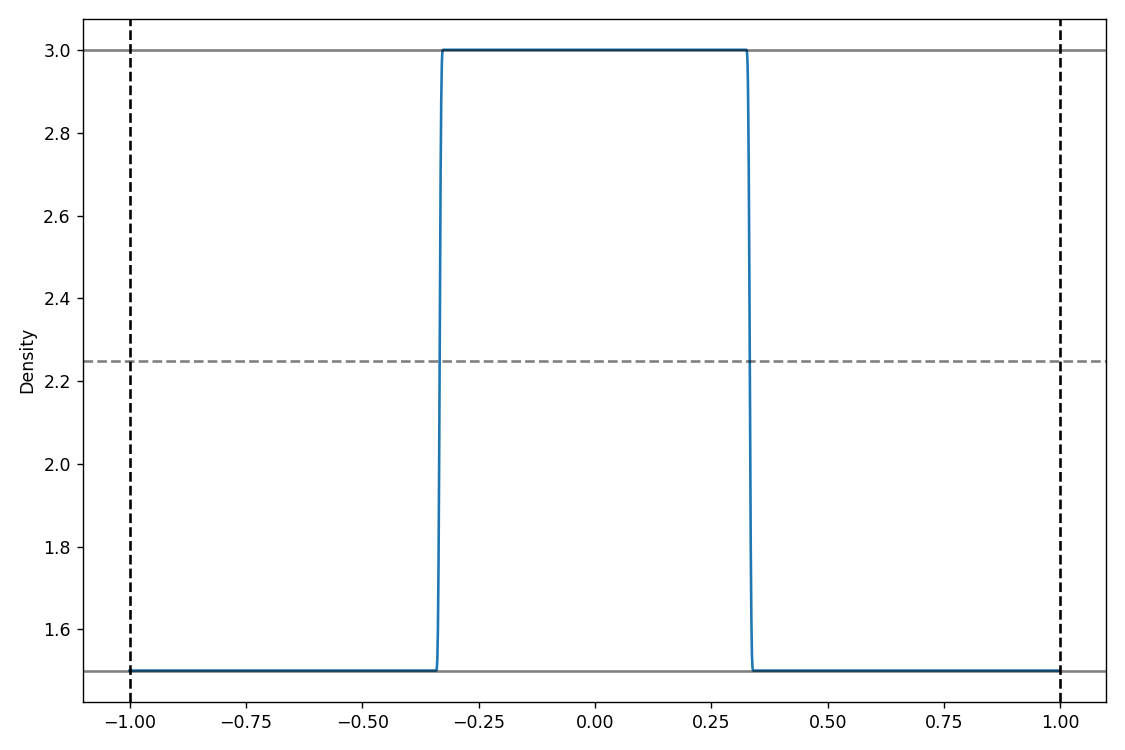

In [4]:
baseArea = 2 / numParticles * 2
particleRadius = baseArea / 2.0
particleSupport = particleRadius * 8.
xsphConstant = 0.1
kappa = 10
restDensity = 1000
dt = 1e-3

timesteps = 2048

minDomain = -1
maxDomain = 1
c0 = 100

diffusionCoefficient = 0.


fluidPositions = ((torch.tensor(sampled)/2 +0.5)* (maxDomain - minDomain) + minDomain)
fluidVelocities = torch.zeros(fluidPositions.shape[0])
fluidAreas = torch.ones_like(fluidPositions) * baseArea
simulationStates = []

plotDensity(fluidPositions, fluidAreas, minDomain, maxDomain, particleSupport)

In [5]:
for i in tqdm(range(timesteps)):
    v1 = torch.clone(fluidVelocities)
    dudt_k1, dxdt_k1, fluidDensity, _ = computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphConstant, particleSupport, dt)    
    
    x_k1 = fluidPositions + 0.5 * dt * dxdt_k1
    x_k1[x_k1 < minDomain] += maxDomain - minDomain
    x_k1[x_k1 > maxDomain] -= maxDomain - minDomain    
    u_k1 = fluidVelocities + 0.5 * dt * dudt_k1    
    dudt_k2, dxdt_k2, _, _ = computeUpdate(x_k1, u_k1, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphConstant, particleSupport, 0.5 * dt)    
    
    x_k2 = fluidPositions + 0.5 * dt * dxdt_k2
    x_k2[x_k2 < minDomain] += maxDomain - minDomain
    x_k2[x_k2 > maxDomain] -= maxDomain - minDomain
    u_k2 = fluidVelocities + 0.5 * dt * dudt_k2
    dudt_k3, dxdt_k3, _, _ = computeUpdate(x_k2, u_k2, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphConstant, particleSupport,  0.5 * dt)    
    
    x_k3 = fluidPositions + dt * dxdt_k3
    x_k3[x_k3 < minDomain] += maxDomain - minDomain
    x_k3[x_k3 > maxDomain] -= maxDomain - minDomain
    u_k3 = fluidVelocities + dt * dudt_k3
    dudt_k4, dxdt_k4, _, fluidPressure = computeUpdate(x_k3, u_k3, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphConstant, particleSupport, dt)    
    
    
#     dudt, dxdt, fluidDensity, fluidPressure = computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphConstant, particleSupport, dt)    
    simulationStates.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4), fluidAreas]))
    
#     fluidVelocities = fluidVelocities + dt* (k1 )
#     fluidPositions = fluidPositions + dt * dxdt
#     fluidVelocities = fluidVelocities + dt * dudt
#     fluidVelocities = fluidVelocities + dt * (k1 )
    fluidVelocities = fluidVelocities + dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4)
    fluidPositions = fluidPositions + dt * fluidVelocities
#     fluidPositions = fluidPositions + dt/6 * (dxdt_k1 + 2* dxdt_k2 + 2 * dxdt_k3 + dxdt_k4)
    
    #  8. Euler integration of velocities and positions
#     fluidVelocities += dt * dudt
#     fluidPositions += dt * fluidVelocities
    #  9. Enforce boundary conditions
    fluidPositions[fluidPositions < minDomain] += maxDomain - minDomain
    fluidPositions[fluidPositions > maxDomain] -= maxDomain - minDomain
    # 10. Resort data for convenience
#     indices = torch.argsort(fluidPositions)
#     fluidPositions = fluidPositions[indices]
#     fluidVelocities = fluidVelocities[indices]
#     fluidAreas = fluidAreas[indices]
# After the simulation has run we stack all the states into one large array for easier slicing and analysis
simulationStates = torch.stack(simulationStates)

  0%|          | 0/2048 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


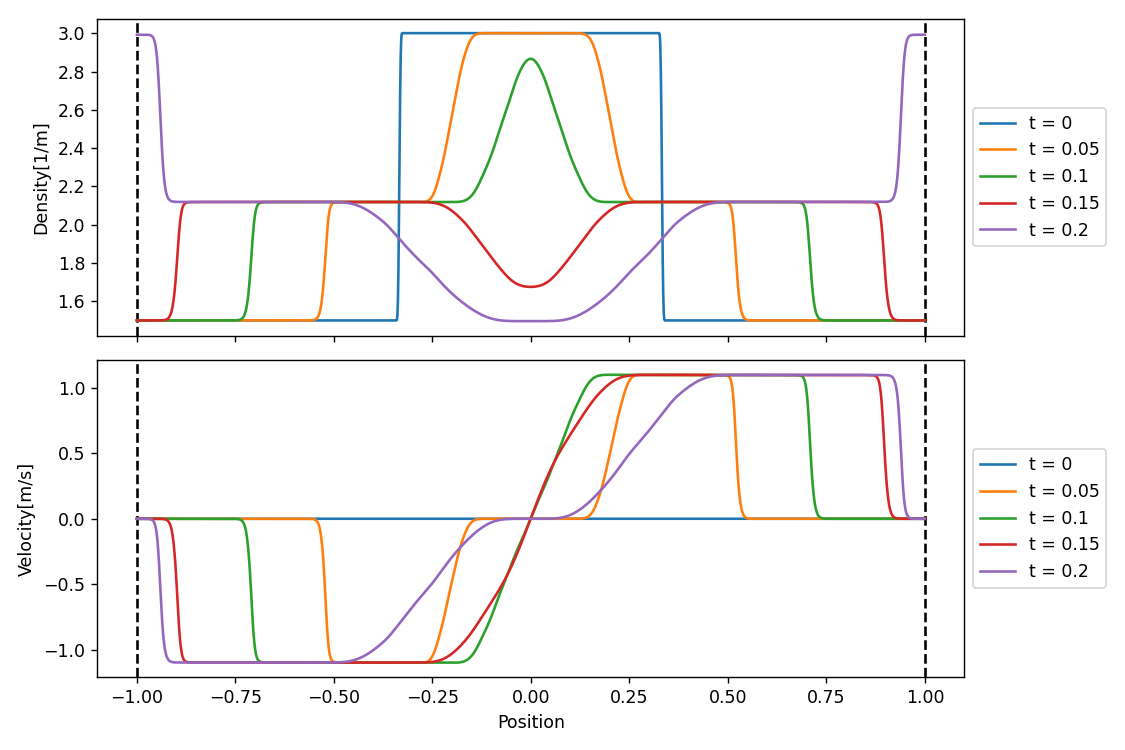

In [6]:
plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = [0, 50, 100, 150, 200])
# plotDistorted(simulationStates, minDomain, maxDomain, dt)
# scatterPlotAll(simulationStates, minDomain, maxDomain, dt)
# regularPlot(simulationStates, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)

<IPython.core.display.Javascript object>


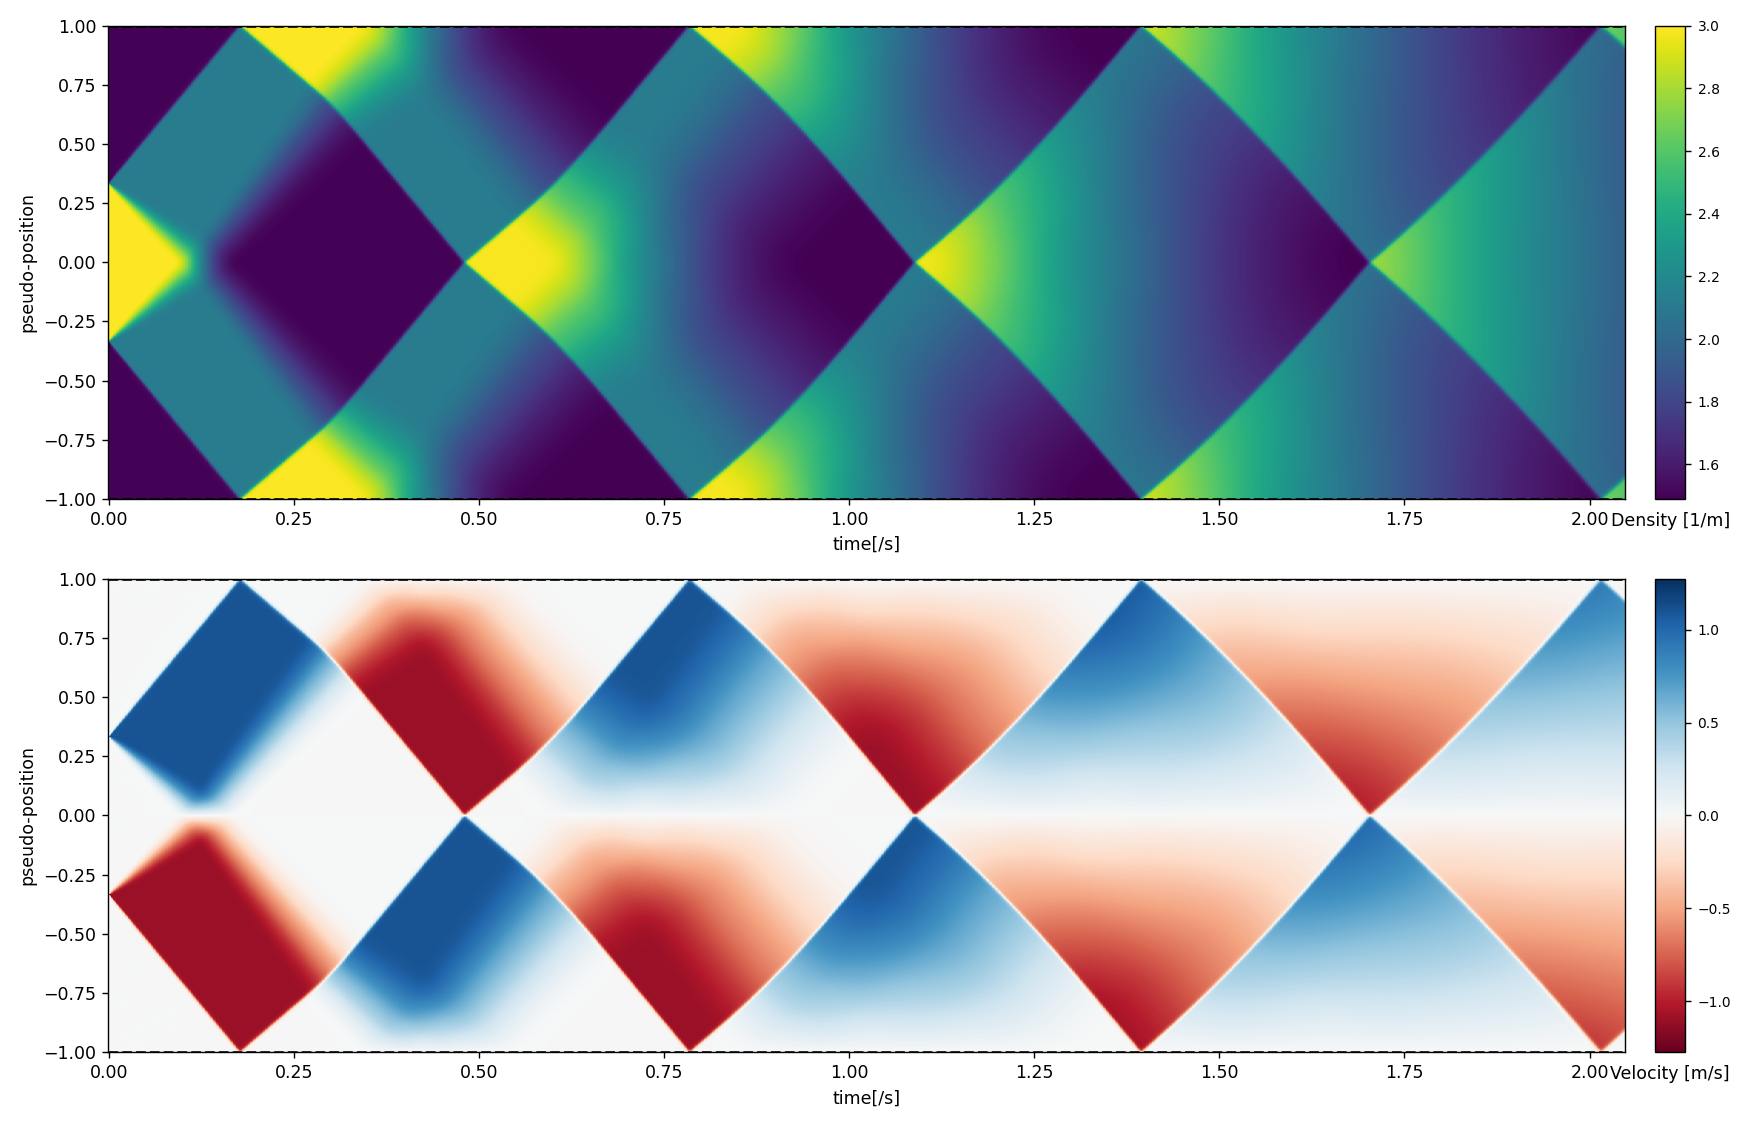

In [7]:
# plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = [])
# plotDistorted(simulationStates, minDomain, maxDomain, dt)
# scatterPlotAll(simulationStates, minDomain, maxDomain, dt)
regularPlot(simulationStates, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)

In [8]:
# plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = [])
# plotDistorted(simulationStates, minDomain, maxDomain, dt)
# scatterPlotAll(simulationStates, minDomain, maxDomain, dt)
# regularPlot(simulationStates, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)

In [9]:
fluidPositions = simulationStates[0,0,:]
fluidAreas = simulationStates[0,-1,:]
ghostPositions = createGhostParticles(fluidPositions, minDomain, maxDomain)
fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
fluidDensity = computeDensity(fluidPositions, fluidAreas, particleSupport, fluidRadialDistances, fluidNeighbors)

In [10]:
timestamps = np.arange(0,simulationStates.shape[0] - 256)

In [11]:
from torch_geometric.loader import DataLoader
batch_size = 4
dataLoader = DataLoader(timestamps, shuffle=True, batch_size = batch_size).batch_sampler
dataIter = iter(dataLoader)

In [12]:
try:
    bdata = next(dataIter)
except:
    dataIter = iter(dataLoader)
    bdata = next(dataIter)

In [13]:
bdata

[1719, 634, 1093, 1662]

In [108]:
positions = [simulationStates[i,0,:] for i in bdata]
areas = [simulationStates[i,-1,:] for i in bdata]
velocities = [simulationStates[i,1,:] for i in bdata]
updates = [simulationStates[i,-2,:] for i in bdata]
#     simulationStates.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4), fluidAreas]))
print(positions)
ghosts = [createGhostParticles(p, minDomain, maxDomain) for p in positions]
print(ghosts)
neighborInformation = [findNeighborhoods(p, g, particleSupport) for p,g in zip(positions, ghosts)]
neighbors = [n[0] for n in neighborInformation]
radialDistances = [n[1] for n in neighborInformation]
distances = [n[2] for n in neighborInformation]
print(neighbors)

densities = [computeDensity(p, a, particleSupport, r, n) for p,a,r,n in zip(positions,areas,radialDistances, neighbors)]
gtDensity = [simulationStates[i,2,:] for i in bdata]

[tensor([ 0.9999, -0.9991, -0.9981,  ...,  0.9969,  0.9979,  0.9989],
       dtype=torch.float64), tensor([-1.0000, -0.9987, -0.9974,  ...,  0.9961,  0.9974,  0.9987],
       dtype=torch.float64), tensor([ 0.9999, -0.9991, -0.9981,  ...,  0.9969,  0.9979,  0.9989],
       dtype=torch.float64), tensor([ 0.9999, -0.9992, -0.9983,  ...,  0.9971,  0.9980,  0.9989],
       dtype=torch.float64)]
[tensor([-1.0001, -2.9991, -2.9981,  ...,  2.9969,  2.9979,  2.9989],
       dtype=torch.float64), tensor([-3.0000, -2.9987, -2.9974,  ...,  2.9961,  2.9974,  2.9987],
       dtype=torch.float64), tensor([-1.0001, -2.9991, -2.9981,  ...,  2.9969,  2.9979,  2.9989],
       dtype=torch.float64), tensor([-1.0001, -2.9992, -2.9983,  ...,  2.9971,  2.9980,  2.9989],
       dtype=torch.float64)]
[tensor([[   0,    0,    0,  ..., 2047, 2047, 2047],
        [   0, 2045, 2046,  ..., 2041, 2042, 2043]]), tensor([[   0,    0,    0,  ..., 2047, 2047, 2047],
        [2043, 2044, 2045,  ..., 2042, 2043, 2044]]), t

In [15]:
err = torch.hstack([torch.mean((rho - gt)**2) for rho,gt in zip(densities, gtDensity)])
print(err)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [16]:
stackedPositions = torch.hstack(positions).type(torch.float32)
stackedAreas = torch.hstack(areas).type(torch.float32)
stackedVelocities = torch.hstack(velocities).type(torch.float32)
stackedUpdates = torch.hstack(velocities).type(torch.float32)
stackedNeighbors = torch.hstack([i * positions[0].shape[0] + neighbors[i] for i in range(len(neighbors))])
stackedRadialDistances = torch.hstack(radialDistances).type(torch.float32)
stackedDistances = torch.hstack(distances).type(torch.float32)
stackedDensities = torch.hstack(densities).type(torch.float32)

In [17]:
from rbfConv import *

  

In [112]:
# outs = []

# for i in range(4096):
#     torch.nn.init.uniform_(layer.weight,-0.05,0.05)
#     outs.append(layer((ones[:,None], ones[:,None]), stackedNeighbors, stackedDistances[:,None]).detach())
    
# means = [torch.mean(o) for o in outs]

# fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = True, sharey = False, squeeze = False)

# axis[0,0].hist(means, bins = 64)

# fig.tight_layout()

In [292]:

def processDataLoaderIter(iterations, e, rollout, ds, dataLoader, dataIter, model, optimizer, train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01):
    with record_function("prcess data loader"): 
        losses = []
        batchIndices = []

        if train:
            model.train(True)
        else:
            model.train(False)

        i = 0
        for b in (pbl := tqdm(range(iterations), leave=False)):
            try:
                bdata = next(dataIter)
            except:
                dataIter = iter(dataLoader)
                bdata = next(dataIter)
                
            with record_function("prcess data loader[batch]"): 
                if train:
                    optimizer.zero_grad()
                positions = [simulationStates[i,0,:] for i in bdata]
                areas = [simulationStates[i,-1,:] for i in bdata]
                velocities = [simulationStates[i,1,:] for i in bdata]
                updates = [simulationStates[i,-2,:] for i in bdata]
                #     simulationStates.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4), fluidAreas]))
#                 print(positions)
                ghosts = [createGhostParticles(p, minDomain, maxDomain) for p in positions]
#                 print(ghosts)
                neighborInformation = [findNeighborhoods(p, g, particleSupport) for p,g in zip(positions, ghosts)]
                neighbors = [n[0] for n in neighborInformation]
                radialDistances = [n[1] for n in neighborInformation]
                distances = [n[2] for n in neighborInformation]
#                 print(neighbors)

                densities = [computeDensity(p, a, particleSupport, r, n) for p,a,r,n in zip(positions,areas,radialDistances, neighbors)]
                gtDensity = [simulationStates[i,2,:] for i in bdata]

                stackedPositions = torch.hstack(positions).type(torch.float32)
                stackedAreas = torch.hstack(areas).type(torch.float32)
                stackedVelocities = torch.hstack(velocities).type(torch.float32)
                stackedUpdates = torch.hstack(updates).type(torch.float32)
                stackedNeighbors = torch.hstack([i * positions[0].shape[0] + neighbors[i] for i in range(len(neighbors))])
                stackedRadialDistances = torch.hstack(radialDistances).type(torch.float32)
                stackedDistances = torch.hstack(distances).type(torch.float32)
                stackedDensities = torch.hstack(densities).type(torch.float32)
                ones = torch.ones_like(stackedAreas)
                
                d = stackedRadialDistances[:,None] * torch.sign(stackedDistances[:,None])
                prediction = model((ones[:,None], ones[:,None]), stackedNeighbors, d)
                loss = torch.mean((prediction - torch.hstack(gtDensity)[:,None])**2)
                
                losses.append(((prediction[:,0] - torch.hstack(densities))**2).detach().cpu().numpy())

#                 with record_function("prcess data loader[batch] - backward"): 
#                     sumLosses = torch.mean(batchLosses[:,:,0]) #+ torch.mean(batchLosses[:,:,1])
                if train:
                    loss.backward()
                    optimizer.step()
                
#                 lossString = np.array2string(torch.mean(batchLosses[:,:,0],dim=0).detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.2e" % x})
                batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))

#                 with portalocker.Lock('README.md', flags = 0x2, timeout = None):
                pbl.set_description('%8s[gpu %d]: %3d [%1d] @ %1.1e: :  %s -> %.2e' %(prefix, 0, e, 0, lr, batchString, loss.detach().cpu().numpy()))
#                 pbl.update()
                pb.set_description('[gpu %d] %90s - Learning: %1.4e' %(0, "", np.mean(np.vstack(losses))))
                pb.update()
                batchIndices.append(bdata)
#                 i = i + 1
#                 if i > 100:
#                     break
        bIndices  = np.hstack(batchIndices)
        losses = np.vstack(losses)

        # idx = np.argsort(bIndices)
        # bIndices = bIndices[idx]
        # losses = losses[idx]

        epochLoss = losses
        return bIndices, epochLoss


In [293]:

def getWindowFunction(windowFunction):
    windowFn = lambda r: torch.ones_like(r)
    if windowFunction == 'cubicSpline':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 3 - 4 * torch.clamp(1/2 - r, min = 0) ** 3
    if windowFunction == 'quarticSpline':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 4 - 5 * torch.clamp(3/5 - r, min = 0) ** 4 + 10 * torch.clamp(1/5- r, min = 0) ** 4
    if windowFunction == 'quinticSpline':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 5 - 6 * torch.clamp(2/3 - r, min = 0) ** 5 + 15 * torch.clamp(1/3 - r, min = 0) ** 5
    if windowFunction == 'Wendland2_1D':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 3 * (1 + 3 * r)
    if windowFunction == 'Wendland4_1D':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 5 * (1 + 5 * r + 8 * r**2)
    if windowFunction == 'Wendland6_1D':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 7 * (1 + 7 * r + 19 * r**2 + 21 * r**3)
    if windowFunction == 'Wendland2':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 4 * (1 + 4 * r)
    if windowFunction == 'Wendland4':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 6 * (1 + 6 * r + 35/3 * r**2)
    if windowFunction == 'Wendland6':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 8 * (1 + 8 * r + 25 * r**2 + 32 * r**3)
    if windowFunction == 'Hoct4':
        def hoct4(x):
            alpha = 0.0927 # Subject to 0 = (1 − α)** nk−2 + A(γ − α)**nk−2 + B(β − α)**nk−2
            beta = 0.5 # Free parameter
            gamma = 0.75 # Free parameter
            nk = 4 # order of kernel

            A = (1 - beta**2) / (gamma ** (nk - 3) * (gamma ** 2 - beta ** 2))
            B = - (1 + A * gamma ** (nk - 1)) / (beta ** (nk - 1))
            P = -nk * (1 - alpha) ** (nk - 1) - nk * A * (gamma - alpha) ** (nk - 1) - nk * B * (beta - alpha) ** (nk - 1)
            Q = (1 - alpha) ** nk + A * (gamma - alpha) ** nk + B * (beta - alpha) ** nk - P * alpha

            termA = P * x + Q
            termB = (1 - x) ** nk + A * (gamma - x) ** nk + B * (beta - x) ** nk
            termC = (1 - x) ** nk + A * (gamma - x) ** nk
            termD = (1 - x) ** nk
            termE = 0 * x

            termA[x > alpha] = 0
            termB[x <= alpha] = 0
            termB[x > beta] = 0
            termC[x <= beta] = 0
            termC[x > gamma] = 0
            termD[x <= gamma] = 0
            termD[x > 1] = 0
            termE[x < 1] = 0

            return termA + termB + termC + termD + termE

        windowFn = lambda r: hoct4(r)
    if windowFunction == 'Spiky':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 3
    if windowFunction == 'Mueller':
        windowFn = lambda r: torch.clamp(1 - r ** 2, min = 0) ** 3
    if windowFunction == 'poly6':
        windowFn = lambda r: torch.clamp((1 - r)**3, min = 0)
    if windowFunction == 'Parabola':
        windowFn = lambda r: torch.clamp(1 - r**2, min = 0)
    if windowFunction == 'Linear':
        windowFn = lambda r: torch.clamp(1 - r, min = 0)
    return windowFn



In [308]:

from torch.optim import Adam

n = 16
basis = 'linear'
computeBatchSize = 128
windowFn = getWindowFunction('Wendland2_1D')
windowFn = None
normalized = False
model = RbfConv(
            in_channels = 1, out_channels = 1,
                dim = 1, size = [n],
                rbf = basis,
                bias = True,
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = 'cartesian',
                batch_size = [computeBatchSize, computeBatchSize], windowFn = windowFn, normalizeWeights = False, normalizeInterpolation = normalized)

ones = torch.ones_like(stackedAreas)
out = model((ones[:,None], ones[:,None]), stackedNeighbors, stackedDistances[:,None])
torch.nn.init.uniform_(model.weight,0.5,1)
print(model.weight)
lr = 1e-2
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)

iterations = 100
epochs = 10
pb = tqdm(range(epochs * iterations))
# pb.reset(total=len(train_dataloader))
lossArray = []
batches = []
for epoch in range(epochs):
    losses = []

    b,l = processDataLoaderIter(iterations, epoch, epoch // 2 + 1, None, dataLoader, dataIter, model, optimizer, True, prefix = 'training', augmentAngle=False, augmentJitter=False, jitterAmount=0.01)
    lossArray.append(l)
    batches.append(b)
#     unroll = max(args.minUnroll, min(epoch // 2 + 1, args.maxUnroll))
    # trainingEpochLoss = processDataLoaderIter(args.iterations, epoch, epoch // 2 + 1, train_ds, train_dataloader, train_iter, model, optimizer, True, prefix = 'training', augmentAngle=args.argumentAngle, augmentJitter=args.augmentJitter, jitterAmount=args.jitterAmount)
#     trainingEpochLoss = processDataLoaderIter(args.iterations, epoch, unroll, train_ds, train_dataloader, train_iter, model, optimizer, True, prefix = 'training', augmentAngle=args.augmentAngle, augmentJitter=args.augmentJitter, jitterAmount=args.jitterAmount)

#     trainingEpochLoss = processDataLoader(epoch,unroll, train_ds, train_dataloader, model, optimizer, True, prefix = 'training')
#     trainingEpochLosses.append(trainingEpochLoss)
    # torch.save(model.state_dict(), './trainingData/%s/model_%03d.torch' % (exportString, epoch))
    if epoch % 1 == 0 and epoch > 0:
        lr = lr * 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']
#     torch.save(model.state_dict(), './trainingData/%s/model_%03d.torch' % (exportString, epoch))


Parameter containing:
tensor([[[0.5287]],

        [[0.9529]],

        [[0.7911]],

        [[0.7889]],

        [[0.8400]],

        [[0.9593]],

        [[0.9759]],

        [[0.9884]],

        [[0.6123]],

        [[0.7856]],

        [[0.5450]],

        [[0.6685]],

        [[0.7187]],

        [[0.5891]],

        [[0.7141]],

        [[0.7936]]], requires_grad=True)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


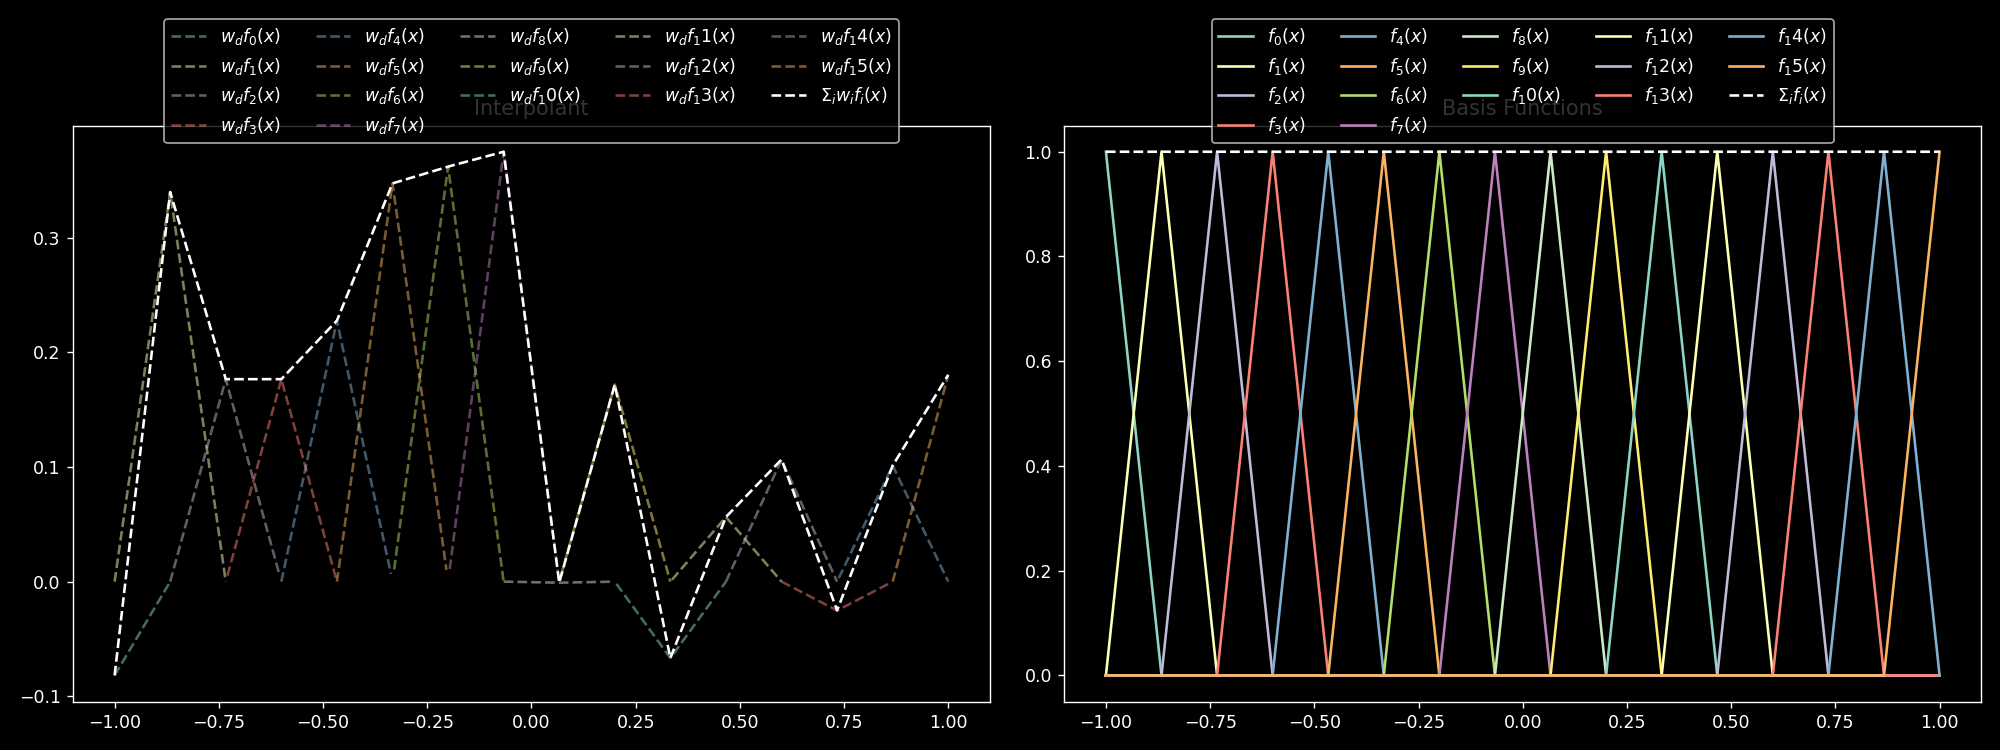

In [309]:
import matplotlib as mpl
plt.style.use('dark_background')
cmap = mpl.colormaps['viridis']

fig, axis = plt.subplots(1, 2, figsize=(16,6), sharex = False, sharey = False, squeeze = False)
#     sc = axis[0,0].scatter(x, y, c = c, s = 1)
#     ax1_divider = make_axes_locatable(axis[0,0])
#     cax1 = ax1_divider.append_axes("bottom", size="20%", pad="2%")
#     cb1 = fig.colorbar(sc, cax=cax1,orientation='horizontal')
#     cb1.ax.tick_params(labelsize=8) 
#     axis[0,0].axvline(minDomain, color = 'black', ls = '--')
#     axis[0,0].axvline(maxDomain, color = 'black', ls = '--')

x =  torch.linspace(-1,1,511)
fx = evalBasisFunction(n, x , which = basis, periodic=False)
# fx = fx / torch.sum(fx, axis = 0)[None,:]
# print(fx)
for y in range(n):
#     print(y)
    axis[0,1].plot(x, fx[y,:], label = '$f_%d(x)$' % y)
axis[0,1].plot(x,torch.sum(fx, axis=0),ls='--',c='white', label = '$\Sigma_i f_i(x)$')
# axis[0,0].legend()
axis[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=5, fancybox=True, shadow=False)
axis[0,1].set_title('Basis Functions')
# x =  torch.linspace(-1,1,255)
# fx = evalBasisFunction(8, x , which = 'linear', periodic=False)
# fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)
for y in range(n):
#     print(y)
    fy = model.weight[:,0][y].detach() * fx[y,:]
    axis[0,0].plot(x[fy != 0], fy[fy != 0], label = '$w_d f_%d(x)$' % y, ls = '--', alpha = 0.5)
# axis[0,1].plot(x,torch.sum(fx, axis=0),ls='--',c='black', label = '$\Sigma_i f_i(x)$')
axis[0,0].plot(x,torch.sum(model.weight[:,0].detach() * fx,axis=0),ls='--',c='white', label = '$\Sigma_i w_i f_i(x)$')
# axis[0,0].legend()
axis[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=5, fancybox=True, shadow=False)

axis[0,0].set_title('Interpolant')
fig.tight_layout()
    

In [311]:

with torch.no_grad():
    bdata = np.arange(len(simulationStates) - 256, len(simulationStates))
    print([i for i in bdata])
    positions = [simulationStates[i,0,:] for i in bdata]
    areas = [simulationStates[i,-1,:] for i in bdata]
    velocities = [simulationStates[i,1,:] for i in bdata]
    updates = [simulationStates[i,-2,:] for i in bdata]
    #     simulationStates.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4), fluidAreas]))
#                 print(positions)
    ghosts = [createGhostParticles(p, minDomain, maxDomain) for p in positions]
#                 print(ghosts)
    neighborInformation = [findNeighborhoods(p, g, particleSupport) for p,g in zip(positions, ghosts)]
    neighbors = [n[0] for n in neighborInformation]
    radialDistances = [n[1] for n in neighborInformation]
    distances = [n[2] for n in neighborInformation]
#                 print(neighbors)

    densities = [computeDensity(p, a, particleSupport, r, n) for p,a,r,n in zip(positions,areas,radialDistances, neighbors)]
    gtDensity = [simulationStates[i,2,:] for i in bdata]
    
#     print([torch.max((d - g)**2) for d,g in zip(densities, gtDensity)])

    stackedPositions = torch.hstack(positions).type(torch.float32)
    stackedAreas = torch.hstack(areas).type(torch.float32)
    stackedVelocities = torch.hstack(velocities).type(torch.float32)
    stackedUpdates = torch.hstack(updates).type(torch.float32)
    stackedNeighbors = torch.hstack([i * positions[0].shape[0] + neighbors[i] for i in range(len(neighbors))])
    stackedRadialDistances = torch.hstack(radialDistances).type(torch.float32)
    stackedDistances = torch.hstack(distances).type(torch.float32)
    stackedDensities = torch.hstack(densities).type(torch.float32)
    ones = torch.ones_like(stackedAreas)

    d = stackedRadialDistances[:,None] * torch.sign(stackedDistances[:,None])
    prediction = model((ones[:,None], ones[:,None]), stackedNeighbors, d)
    loss = torch.mean((prediction - torch.hstack(densities)[:,None])**2)
#     print(loss)
#     losses.append(((prediction - torch.hstack(gtDensity)[:,None])**2).detach().cpu().numpy())

[1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 195

In [312]:
print(stackedPositions.shape)
print(ones.shape)
print(d.shape)
print(stackedNeighbors.shape)
print(prediction.shape)

torch.Size([524288])
torch.Size([524288])
torch.Size([8530940, 1])
torch.Size([2, 8530940])
torch.Size([524288, 1])


In [313]:

# bdata = np.arange(len(simulationStates) - 256, len(simulationStates) - 256 + 16)
# positions = [simulationStates[i,0,:] for i in bdata]

# stackedPositions2 = torch.vstack(positions).type(torch.float32).flatten()

# pS = stackedPositions2.reshape((bdata.shape[0], positions[0].shape[0]))
# print(pS[0,:] - positions[0])

In [314]:
bdata.shape[0]

256

<IPython.core.display.Javascript object>


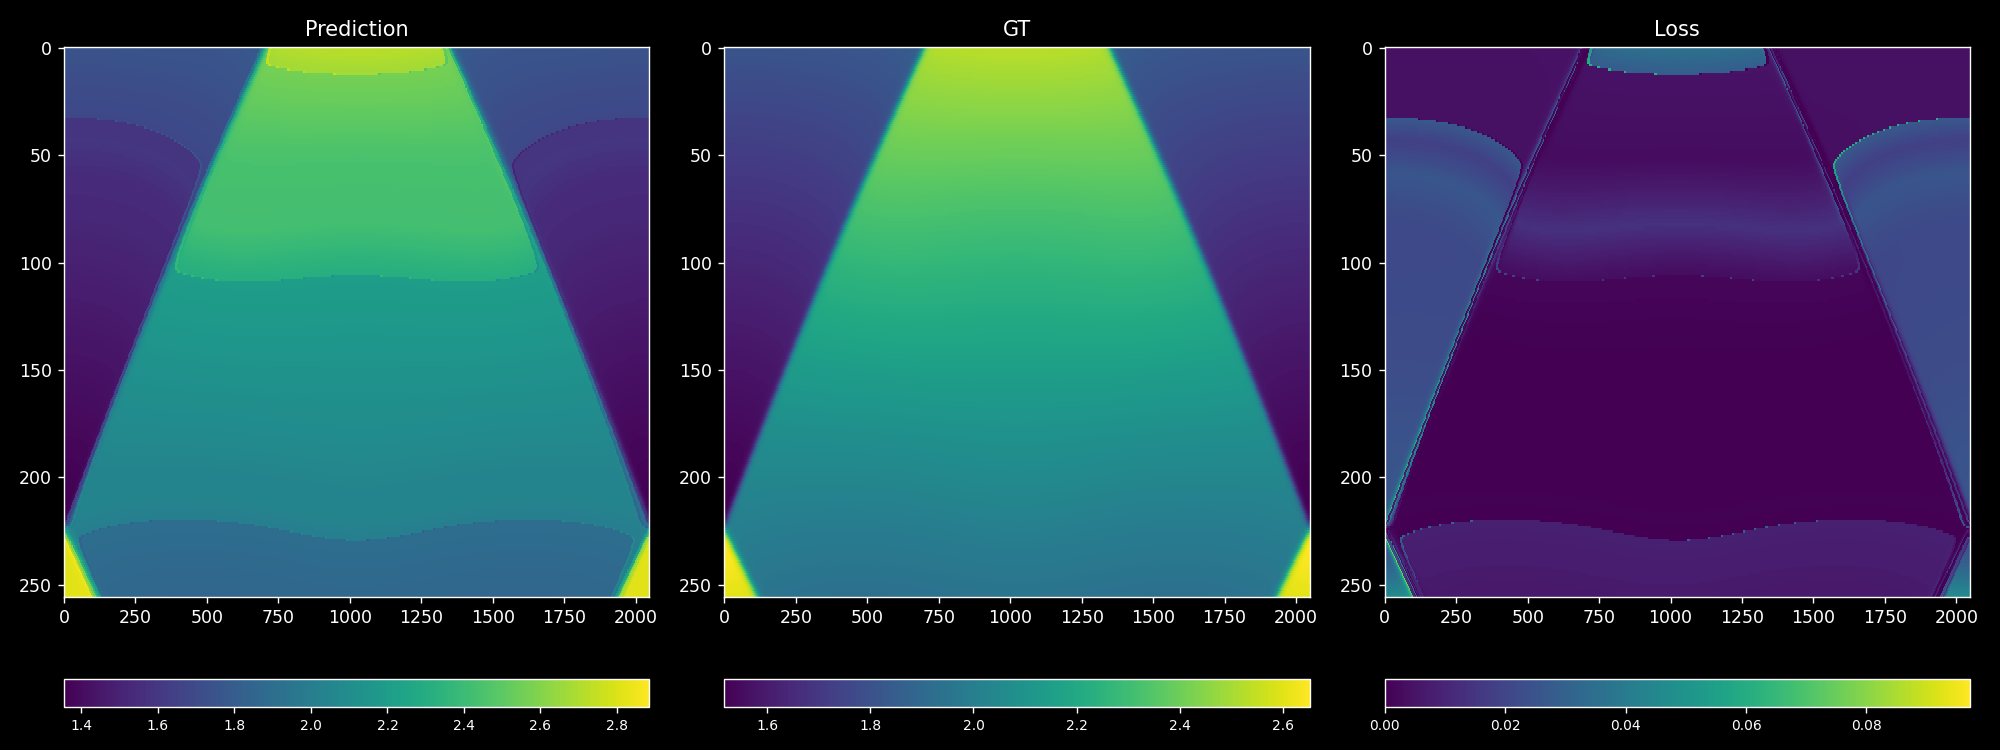

In [315]:

fig, axis = plt.subplots(1, 3, figsize=(16,6), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('Prediction')
im = axis[0,0].imshow(prediction.reshape((bdata.shape[0], positions[0].shape[0])), interpolation = 'nearest')
axis[0,0].axis('auto')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="15%")
cbarPredFFT = fig.colorbar(im, cax=cax1,orientation='horizontal')
cbarPredFFT.ax.tick_params(labelsize=8) 

axis[0,1].set_title('GT')
im = axis[0,1].imshow(torch.hstack(densities).reshape((bdata.shape[0], positions[0].shape[0])), interpolation = 'nearest')
axis[0,1].axis('auto')
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="15%")
cbarPredFFT = fig.colorbar(im, cax=cax1,orientation='horizontal')
cbarPredFFT.ax.tick_params(labelsize=8) 

axis[0,2].set_title('Loss')
im = axis[0,2].imshow(((prediction - torch.hstack(gtDensity)[:,None])**2).reshape((bdata.shape[0], positions[0].shape[0])), interpolation = 'nearest')
axis[0,2].axis('auto')
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="15%")
cbarPredFFT = fig.colorbar(im, cax=cax1,orientation='horizontal')
cbarPredFFT.ax.tick_params(labelsize=8) 

fig.tight_layout()